In [ ]:
print('jai shree radha ramana baktha kolahala jai shrere premikendra')

jai shree radha ramana baktha kolahala jai shrere premikendra


## Step 1: Load and validate virome count data

In [ ]:
# ================================
# Imports
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

# ================================
# Mount Google Drive (Colab only)
# ================================
from google.colab import drive
drive.mount('/content/drive')

# ================================
# Load virome count data
# ================================
file_path = "/content/drive/MyDrive/Metagenomics.csv"
df = pd.read_csv(file_path)

# ================================
# Basic validation
# ================================
required_columns = {"Taxon", "Count"}
missing_cols = required_columns - set(df.columns)

if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

# Ensure Count is numeric
df["Count"] = pd.to_numeric(df["Count"], errors="coerce").fillna(0).astype(int)

# Remove zero-count entries (optional but recommended)
df = df[df["Count"] > 0].reset_index(drop=True)

# ================================
# Summary statistics
# ================================
total_reads = df["Count"].sum()
num_taxa = df.shape[0]

print(f"Total reads: {total_reads:,}")
print(f"Number of detected taxa: {num_taxa}")

df.head()


Mounted at /content/drive
Total reads: 379,278
Number of detected taxa: 1015


,Taxon,Count
0,Hemileuca_sp._nucleopolyhedrovirus,7
1,Perigonia_lusca_single_nucleopolyhedrovirus,2
2,unclassified_dsDNA_viruses,3
3,Musca_domestica_salivary_gland_hypertrophy_virus,35
4,Oxbow_virus,36


## Step 2: Calculate relative abundance

In [ ]:
# ================================
# Relative abundance calculation
# ================================

if total_reads == 0:
    raise ValueError("Total read count is zero. Cannot compute relative abundance.")

df["Relative_Abundance"] = (df["Count"] / total_reads) * 100

# Quick sanity check
print(
    f"Relative abundance range: "
    f"{df['Relative_Abundance'].min():.4f}% – "
    f"{df['Relative_Abundance'].max():.4f}%"
)

df[["Taxon", "Count", "Relative_Abundance"]].head()


Relative abundance range: 0.0003% – 82.9803%


,Taxon,Count,Relative_Abundance
0,Hemileuca_sp._nucleopolyhedrovirus,7,0.001846
1,Perigonia_lusca_single_nucleopolyhedrovirus,2,0.000527
2,unclassified_dsDNA_viruses,3,0.000791
3,Musca_domestica_salivary_gland_hypertrophy_virus,35,0.009228
4,Oxbow_virus,36,0.009492


## Step 3: Alpha diversity metrics (Shannon, Simpson, Richness)


In [ ]:
# ================================
# Alpha diversity calculations
# ================================

if df.empty:
    raise ValueError("Dataframe is empty. Cannot compute diversity metrics.")

if total_reads == 0:
    raise ValueError("Total reads is zero. Cannot compute diversity metrics.")

# Relative proportions
p = df["Count"] / total_reads

# Shannon diversity (entropy)
shannon = entropy(p, base=np.e)

# Simpson diversity (1 - dominance)
simpson = 1 - np.sum(p ** 2)

# Richness (number of detected taxa)
richness = df.shape[0]

# Store results in a clean table
alpha_diversity = pd.DataFrame({
    "Metric": ["Shannon", "Simpson", "Richness"],
    "Value": [shannon, simpson, richness]
})

alpha_diversity


,Metric,Value
0,Shannon,1.213346
1,Simpson,0.309787
2,Richness,1015.000000


## Step 4: Top dominant viral taxa (absolute abundance)



/tmp/ipython-input-2722982172.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


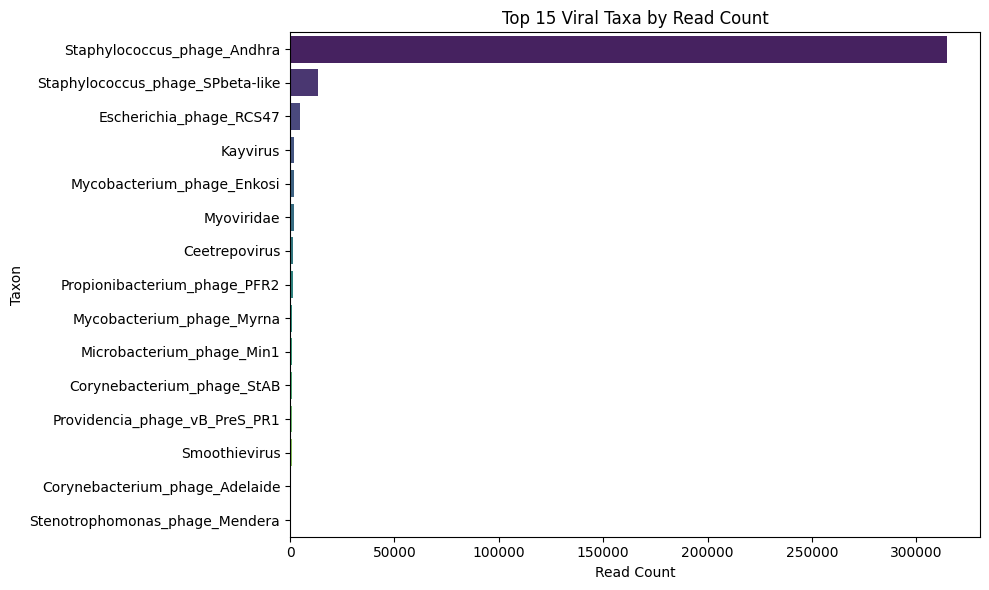

In [ ]:
# ================================
# Top dominant taxa visualization
# ================================

if df.empty:
    raise ValueError("Dataframe is empty. Cannot plot dominant taxa.")

# Select top taxa (handles cases with <15 taxa automatically)
top_n = 15
top_taxa = df.sort_values("Count", ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_taxa,
    y="Taxon",
    x="Count",
    palette="viridis"
)

plt.title(f"Top {len(top_taxa)} Viral Taxa by Read Count")
plt.xlabel("Read Count")
plt.ylabel("Taxon")
plt.tight_layout()

plt.show()


## Step 5: Rank–abundance curve (log–log scale)


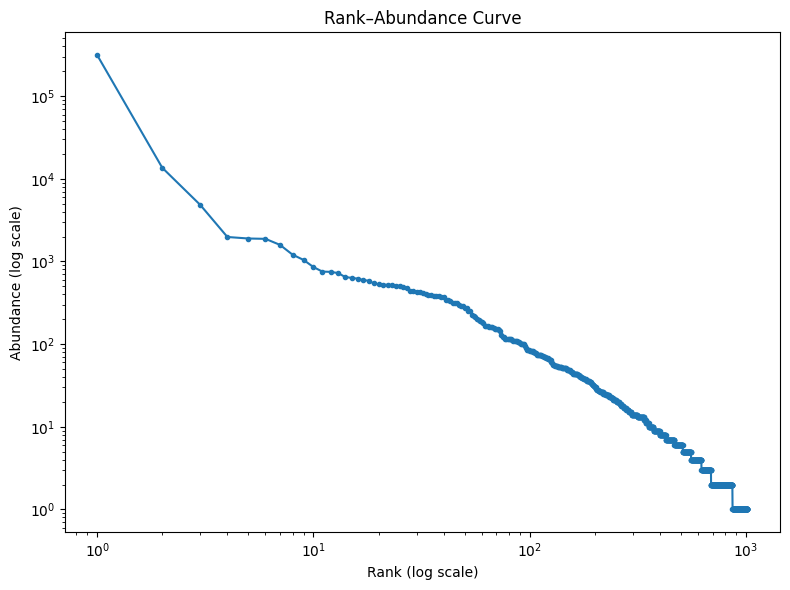

In [ ]:
# ================================
# Rank–abundance curve
# ================================

if df.empty:
    raise ValueError("Dataframe is empty. Cannot generate rank–abundance curve.")

# Extract and sort abundance values
sorted_counts = (
    df["Count"]
    .sort_values(ascending=False)
    .values
)

# Remove zero counts if any remain
sorted_counts = sorted_counts[sorted_counts > 0]

if len(sorted_counts) == 0:
    raise ValueError("No non-zero counts available for rank–abundance plotting.")

ranks = np.arange(1, len(sorted_counts) + 1)

plt.figure(figsize=(8, 6))
plt.plot(ranks, sorted_counts, marker="o", linestyle="-", markersize=3)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Rank (log scale)")
plt.ylabel("Abundance (log scale)")
plt.title("Rank–Abundance Curve")

plt.tight_layout()
plt.show()


## Step 6: Conservative taxonomy, host inference, and One Health classification

In [ ]:
# ================================
#Conservative taxonomy & One Health classification
# ================================

import re

def extract_viral_family(taxon_name):
    """
    Extract viral family using nomenclature rules (ICTV-style).
    Returns family name or 'Unresolved'.
    """
    n = taxon_name.lower()

    # Explicit common phage families
    phage_families = [
        "myoviridae",
        "siphoviridae",
        "podoviridae"
    ]

    for fam in phage_families:
        if fam in n:
            return fam.capitalize()

    # General viral family pattern (*viridae)
    match = re.search(r"\b([a-z]+viridae)\b", n)
    if match:
        return match.group(1).capitalize()

    return "Unresolved"


def classify_taxon_safe(taxon_name):
    """
    Conservative taxonomy and One Health inference.
    Avoids forced biological assumptions and tracks uncertainty explicitly.
    """

    n = taxon_name.lower()

    # --------------------------------
    # Detection level (structural)
    # --------------------------------
    if "unclassified" in n:
        detected_level = "Unclassified"
    elif "viridae" in n:
        detected_level = "Family"
    elif len(taxon_name.split("_")) >= 2:
        detected_level = "Species"
    elif len(taxon_name.split("_")) == 1:
        detected_level = "Genus"
    else:
        detected_level = "Higher"

    # --------------------------------
    # Virus type
    # --------------------------------
    if "phage" in n:
        virus_type = "Phage"
    elif "virus" in n:
        virus_type = "Eukaryotic virus"
    else:
        virus_type = "Unknown"

    # --------------------------------
    # Family assignment (generalized)
    # --------------------------------
    family_assigned = extract_viral_family(taxon_name)

    # --------------------------------
    # Host inference + confidence
    # --------------------------------
    if virus_type == "Phage":
        host_inference = "Bacterial"
        host_confidence = "High"

    elif any(x in n for x in ["herpes", "papilloma", "pox", "adeno"]):
        host_inference = "Mammal-associated"
        host_confidence = "High"

    elif any(x in n for x in ["avian", "gallid", "chicken", "fowl"]):
        host_inference = "Bird-associated"
        host_confidence = "Medium"

    elif any(x in n for x in ["baculovirus", "ascovirus", "nudivirus"]):
        host_inference = "Insect-associated"
        host_confidence = "High"

    elif any(x in n for x in ["algae", "chlorella", "micromonas", "ostreococcus"]):
        host_inference = "Environmental"
        host_confidence = "Medium"

    else:
        host_inference = "Unknown"
        host_confidence = "Low"

    # --------------------------------
    # One Health relevance (derived)
    # --------------------------------
    if host_inference == "Mammal-associated" and host_confidence == "High":
        one_health = "High"
    elif host_inference in ["Bird-associated", "Insect-associated"] and host_confidence in ["High", "Medium"]:
        one_health = "Moderate"
    elif host_inference in ["Environmental", "Bacterial"]:
        one_health = "Low"
    else:
        one_health = "Uncertain"

    # --------------------------------
    # Spillover potential (3-level)
    # --------------------------------
    if host_inference == "Mammal-associated":
        spillover = "Likely"
    elif host_inference in ["Bird-associated", "Insect-associated"]:
        spillover = "Possible"
    elif host_inference in ["Environmental", "Bacterial"]:
        spillover = "Not evident"
    else:
        spillover = "Possible"

    return (
        detected_level,
        virus_type,
        family_assigned,
        host_inference,
        host_confidence,
        one_health,
        spillover
    )


# Apply classification to dataframe
taxonomy_cols = [
    "Detected_Level",
    "Virus_Type",
    "Family_Assigned",
    "Host_Inference",
    "Host_Confidence",
    "OneHealth_Relevance",
    "Spillover_Potential"
]

df[taxonomy_cols] = df["Taxon"].apply(
    lambda x: pd.Series(classify_taxon_safe(x))
)

df[taxonomy_cols + ["Taxon", "Count"]].head()


,Detected_Level,Virus_Type,Family_Assigned,Host_Inference,Host_Confidence,OneHealth_Relevance,Spillover_Potential,Taxon,Count
0,Species,Eukaryotic virus,Unresolved,Unknown,Low,Uncertain,Possible,Hemileuca_sp._nucleopolyhedrovirus,7
1,Species,Eukaryotic virus,Unresolved,Unknown,Low,Uncertain,Possible,Perigonia_lusca_single_nucleopolyhedrovirus,2
2,Unclassified,Eukaryotic virus,Unresolved,Unknown,Low,Uncertain,Possible,unclassified_dsDNA_viruses,3
3,Species,Eukaryotic virus,Unresolved,Unknown,Low,Uncertain,Possible,Musca_domestica_salivary_gland_hypertrophy_virus,35
4,Species,Eukaryotic virus,Unresolved,Unknown,Low,Uncertain,Possible,Oxbow_virus,36


## Step 7A: Taxa with high One Health relevance

In [ ]:
# ================================
# High One Health relevance taxa
# ================================

high_one_health = (
    df[df["OneHealth_Relevance"] == "High"]
    .sort_values("Count", ascending=False)
)

high_one_health[[
    "Taxon",
    "Count",
    "Family_Assigned",
    "Host_Inference",
    "Host_Confidence"
]].head(20)


,Taxon,Count,Family_Assigned,Host_Inference,Host_Confidence
1010,Fowl_aviadenovirus_D,334,Unresolved,Mammal-associated,High
593,Bovine_alphaherpesvirus_5,114,Unresolved,Mammal-associated,High
595,Bubaline_alphaherpesvirus_1,109,Unresolved,Mammal-associated,High
11,Felis_catus_gammaherpesvirus_1,79,Unresolved,Mammal-associated,High
618,Cyprinid_herpesvirus_1,59,Unresolved,Mammal-associated,High
998,Pseudocowpox_virus,50,Unresolved,Mammal-associated,High
603,Caviid_betaherpesvirus_2,48,Unresolved,Mammal-associated,High
617,Cyprinid_herpesvirus_3,47,Unresolved,Mammal-associated,High
585,Cercopithecine_alphaherpesvirus_2,43,Unresolved,Mammal-associated,High
619,Cyprinid_herpesvirus_2,39,Unresolved,Mammal-associated,High


## Step 7B: Taxa with potential spillover relevance


In [ ]:
# ================================
# Spillover-relevant taxa
# ================================

spillover_taxa = (
    df[df["Spillover_Potential"].isin(["Likely", "Possible"])]
    .sort_values("Count", ascending=False)
)

spillover_taxa[[
    "Taxon",
    "Count",
    "Spillover_Potential",
    "Host_Inference",
    "Host_Confidence"
]].head(20)


,Taxon,Count,Spillover_Potential,Host_Inference,Host_Confidence
516,Kayvirus,1979,Possible,Unknown,Low
399,Myoviridae,1879,Possible,Unknown,Low
485,Ceetrepovirus,1589,Possible,Unknown,Low
471,Smoothievirus,724,Possible,Unknown,Low
400,Siphoviridae,620,Possible,Unknown,Low
247,unclassified_Samwavirus,530,Possible,Unknown,Low
93,unclassified_Siphoviridae,508,Possible,Unknown,Low
476,Bongovirus,433,Possible,Unknown,Low
451,Liefievirus,431,Possible,Unknown,Low
443,Fromanvirus,400,Possible,Unknown,Low


## Step 7C: Environmental or unclassified host taxa


In [ ]:
# ================================
# Environmental / unknown host taxa
# ================================

environmental_unknown = (
    df[df["Host_Inference"].isin(["Environmental", "Unknown"])]
    .sort_values("Count", ascending=False)
)

environmental_unknown[[
    "Taxon",
    "Count",
    "Family_Assigned",
    "Host_Inference"
]].head(20)


,Taxon,Count,Family_Assigned,Host_Inference
516,Kayvirus,1979,Unresolved,Unknown
399,Myoviridae,1879,Myoviridae,Unknown
485,Ceetrepovirus,1589,Unresolved,Unknown
471,Smoothievirus,724,Unresolved,Unknown
400,Siphoviridae,620,Siphoviridae,Unknown
247,unclassified_Samwavirus,530,Unresolved,Unknown
93,unclassified_Siphoviridae,508,Siphoviridae,Unknown
476,Bongovirus,433,Unresolved,Unknown
451,Liefievirus,431,Unresolved,Unknown
443,Fromanvirus,400,Unresolved,Unknown


## Step 8A: Prepare summary datasets for visualization


In [ ]:
# ================================
# Prepare datasets for visualization
# ================================

# Top spillover-relevant taxa
top_spillover = (
    df[df["Spillover_Potential"].isin(["Likely", "Possible"])]
    .sort_values("Count", ascending=False)
    .head(10)
)

# Top high One Health relevance taxa
top_high_one_health = (
    df[df["OneHealth_Relevance"] == "High"]
    .sort_values("Count", ascending=False)
    .head(10)
)

# Host inference distribution
host_distribution = df["Host_Inference"].value_counts()

# One Health relevance distribution
one_health_distribution = df["OneHealth_Relevance"].value_counts()


## Step 8B: Multi-panel One Health virome summary


/tmp/ipython-input-1704843517.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-1704843517.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-1704843517.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


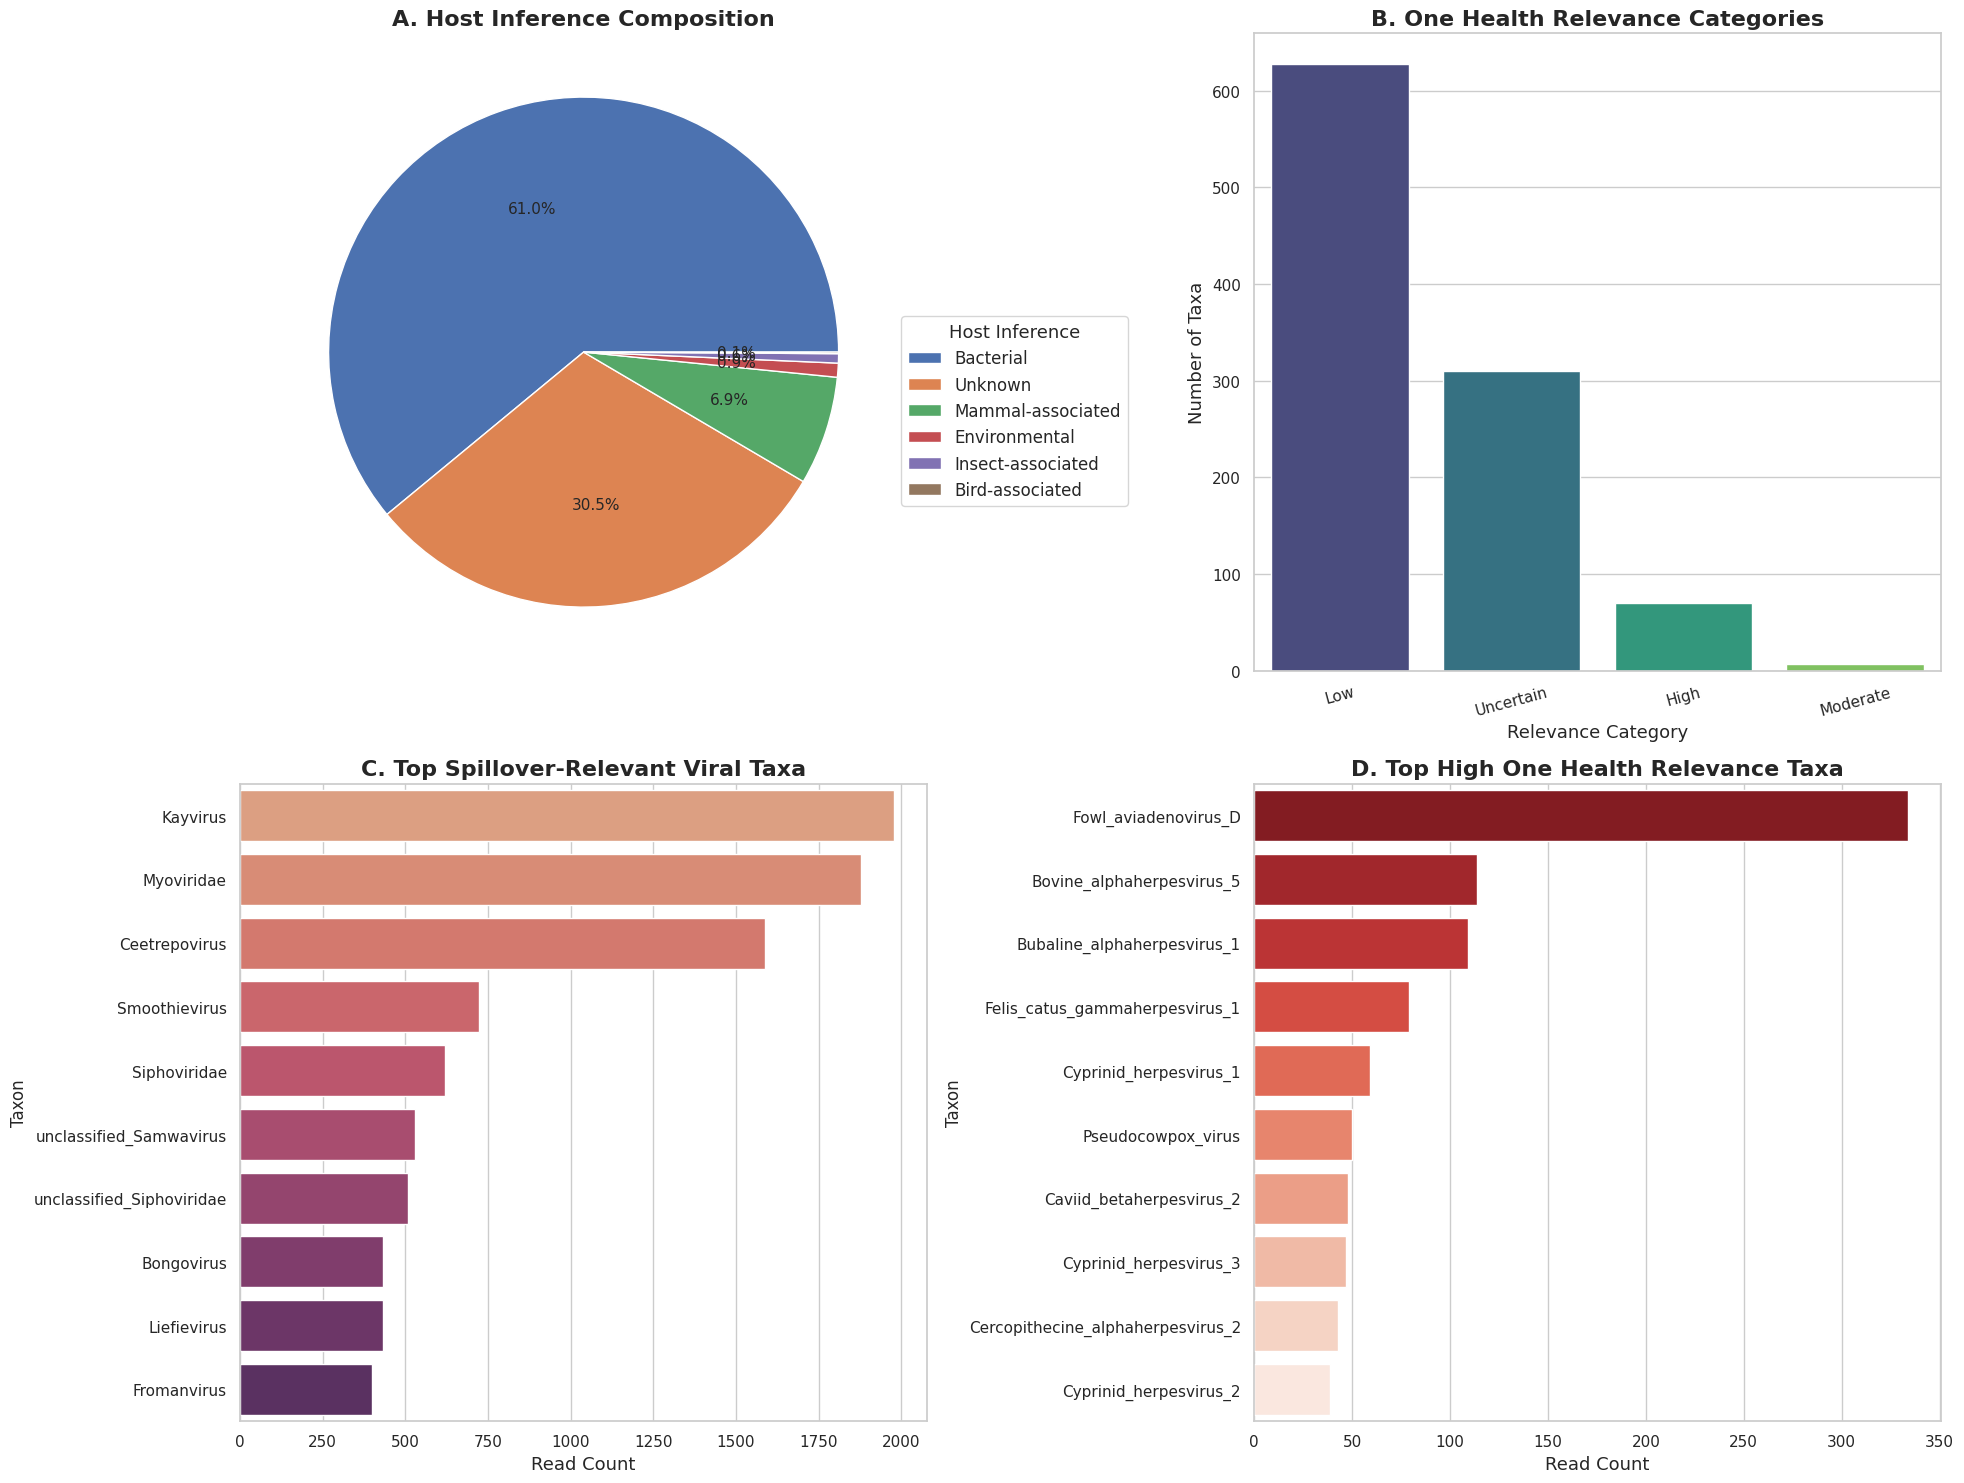

In [ ]:
# ================================
# Multi-panel One Health summary figure
# ================================

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(22, 15))

# ----------------------------
# PANEL A — Host inference composition
# ----------------------------
wedges, texts, autotexts = axes[0, 0].pie(
    host_distribution,
    autopct="%1.1f%%",
    textprops={"fontsize": 11}
)

axes[0, 0].set_title(
    "A. Host Inference Composition",
    fontsize=16,
    fontweight="bold"
)

fig.legend(
    wedges,
    host_distribution.index,
    title="Host Inference",
    loc="center right",
    bbox_to_anchor=(0.52, 0.72),
    fontsize=12,
    title_fontsize=13
)

# ----------------------------
# PANEL B — One Health relevance distribution
# ----------------------------
sns.barplot(
    x=one_health_distribution.index,
    y=one_health_distribution.values,
    palette="viridis",
    ax=axes[0, 1]
)

axes[0, 1].set_title(
    "B. One Health Relevance Categories",
    fontsize=16,
    fontweight="bold"
)
axes[0, 1].set_xlabel("Relevance Category", fontsize=13)
axes[0, 1].set_ylabel("Number of Taxa", fontsize=13)
axes[0, 1].tick_params(axis="x", rotation=15)

# ----------------------------
# PANEL C — Top spillover-relevant taxa
# ----------------------------
sns.barplot(
    data=top_spillover,
    x="Count",
    y="Taxon",
    palette="flare",
    ax=axes[1, 0]
)

axes[1, 0].set_title(
    "C. Top Spillover-Relevant Viral Taxa",
    fontsize=16,
    fontweight="bold"
)
axes[1, 0].set_xlabel("Read Count", fontsize=13)
axes[1, 0].set_ylabel("Taxon", fontsize=12)

# ----------------------------
# PANEL D — Top high One Health relevance taxa
# ----------------------------
sns.barplot(
    data=top_high_one_health,
    x="Count",
    y="Taxon",
    palette="Reds_r",
    ax=axes[1, 1]
)

axes[1, 1].set_title(
    "D. Top High One Health Relevance Taxa",
    fontsize=16,
    fontweight="bold"
)
axes[1, 1].set_xlabel("Read Count", fontsize=13)
axes[1, 1].set_ylabel("Taxon", fontsize=12)

# ----------------------------
# Layout adjustment
# ----------------------------
plt.tight_layout(rect=[0, 0, 0.90, 1])
plt.show()


## Step 9: Automated One Health summary


In [ ]:
# ================================
# Automated One Health summary text
# ================================

summary_lines = []

# Overall counts
summary_lines.append(f"Total viral taxa detected: {len(df)}")

summary_lines.append(
    f"High One Health relevance taxa: "
    f"{(df['OneHealth_Relevance'] == 'High').sum()}"
)

summary_lines.append(
    f"Taxa with potential spillover relevance: "
    f"{df['Spillover_Potential'].isin(['Likely', 'Possible']).sum()}"
)

summary_lines.append(
    f"Environmental or unclassified host taxa: "
    f"{df['Host_Inference'].isin(['Environmental', 'Unknown']).sum()}"
)

# Top dominant taxa
top_taxa = df.sort_values("Count", ascending=False).head(5)

summary_lines.append("\nTop 5 most abundant viral taxa:")
for _, row in top_taxa.iterrows():
    summary_lines.append(
        f"- {row['Taxon']} ({row['Count']} reads)"
    )

# Combine summary text
one_health_summary_text = "\n".join(summary_lines)

print(one_health_summary_text)


Total viral taxa detected: 1015
High One Health relevance taxa: 70
Taxa with potential spillover relevance: 387
Environmental or unclassified host taxa: 319

Top 5 most abundant viral taxa:
- Staphylococcus_phage_Andhra (314726 reads)
- Staphylococcus_phage_SPbeta-like (13614 reads)
- Escherichia_phage_RCS47 (4823 reads)
- Kayvirus (1979 reads)
- Mycobacterium_phage_Enkosi (1897 reads)


## Step 10: Abundance of viral families


/tmp/ipython-input-3374514240.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


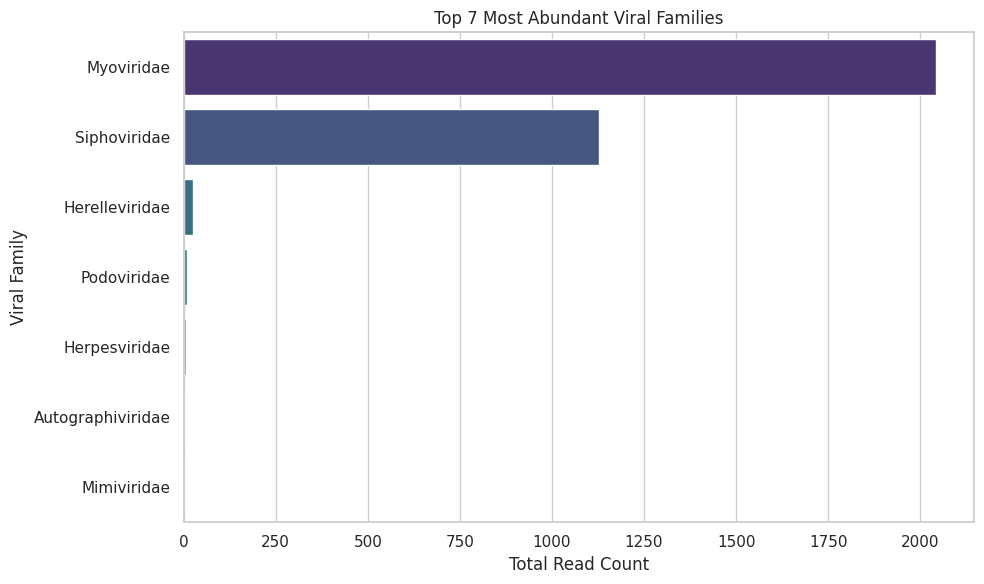

In [18]:
# ================================
# Viral family-level abundance
# ================================

# Exclude unresolved family assignments
family_counts = (
    df[df["Family_Assigned"] != "Unresolved"]
    .groupby("Family_Assigned")["Count"]
    .sum()
    .reset_index()
)

# Select top families
top_n = 10
top_families = (
    family_counts
    .sort_values("Count", ascending=False)
    .head(top_n)
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_families,
    x="Count",
    y="Family_Assigned",
    palette="viridis"
)

plt.title(f"Top {len(top_families)} Most Abundant Viral Families")
plt.xlabel("Total Read Count")
plt.ylabel("Viral Family")

plt.tight_layout()
plt.show()



## Step 11: One Health relevance distribution by host inference

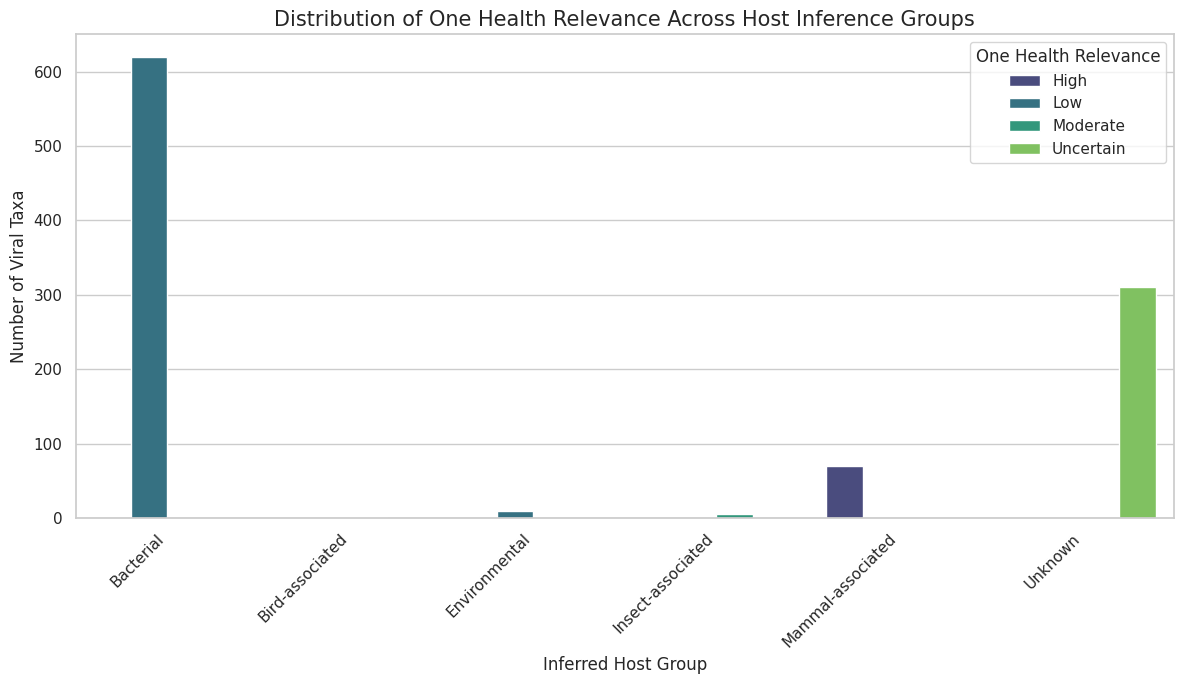

In [19]:
# ================================
# One Health relevance vs host inference
# ================================

# Crosstab of host inference vs One Health relevance
risk_hostgroup = pd.crosstab(
    df["Host_Inference"],
    df["OneHealth_Relevance"]
)

# Convert to long format for plotting
risk_hostgroup_melted = (
    risk_hostgroup
    .reset_index()
    .melt(
        id_vars="Host_Inference",
        var_name="OneHealth_Relevance",
        value_name="Count"
    )
)

plt.figure(figsize=(12, 7))
sns.barplot(
    data=risk_hostgroup_melted,
    x="Host_Inference",
    y="Count",
    hue="OneHealth_Relevance",
    palette="viridis"
)

plt.title(
    "Distribution of One Health Relevance Across Host Inference Groups",
    fontsize=15
)
plt.xlabel("Inferred Host Group")
plt.ylabel("Number of Viral Taxa")
plt.xticks(rotation=45, ha="right")
plt.legend(title="One Health Relevance")

plt.tight_layout()
plt.show()


## Step 12: Dominant viruses within each inferred host group


In [20]:
# ================================
# Top viruses per host inference group
# ================================

top_n = 5
host_groups = df["Host_Inference"].dropna().unique()

top_viruses_by_host = {}

for host in host_groups:
    filtered_df = df[df["Host_Inference"] == host]

    if filtered_df.empty:
        continue

    top_viruses = (
        filtered_df
        .sort_values("Count", ascending=False)
        .head(top_n)
    )

    top_viruses_by_host[host] = top_viruses

    # Console-friendly summary (useful for notebook review)
    print(f"\nTop {top_n} viruses for host group: {host}")
    for _, row in top_viruses.iterrows():
        print(f"- {row['Taxon']}: {row['Count']} reads")



Top 5 viruses for host group: Unknown
- Kayvirus: 1979 reads
- Myoviridae: 1879 reads
- Ceetrepovirus: 1589 reads
- Smoothievirus: 724 reads
- Siphoviridae: 620 reads

Top 5 viruses for host group: Mammal-associated
- Fowl_aviadenovirus_D: 334 reads
- Bovine_alphaherpesvirus_5: 114 reads
- Bubaline_alphaherpesvirus_1: 109 reads
- Felis_catus_gammaherpesvirus_1: 79 reads
- Cyprinid_herpesvirus_1: 59 reads

Top 5 viruses for host group: Bacterial
- Staphylococcus_phage_Andhra: 314726 reads
- Staphylococcus_phage_SPbeta-like: 13614 reads
- Escherichia_phage_RCS47: 4823 reads
- Mycobacterium_phage_Enkosi: 1897 reads
- Propionibacterium_phage_PFR2: 1211 reads

Top 5 viruses for host group: Bird-associated
- Chicken_parvovirus_ABU-P1: 8 reads

Top 5 viruses for host group: Environmental
- Acanthocystis_turfacea_chlorella_virus_1: 15 reads
- Micromonas_pusilla_virus_SP1: 11 reads
- Paramecium_bursaria_Chlorella_virus_1: 7 reads
- Micromonas_sp._RCC1109_virus_MpV1: 7 reads
- Paramecium_bursar

## Step 13: Host-specific virome diversity metrics

In [25]:
# ================================
# Host-specific diversity metrics
# ================================

def calculate_diversity_indices(counts):
    total = counts.sum()
    if total == 0:
        return pd.Series({
            "Shannon_Diversity": 0,
            "Simpson_Diversity": 0
        })

    p = counts / total

    return pd.Series({
        "Shannon_Diversity": entropy(p, base=np.e),
        "Simpson_Diversity": 1 - np.sum(p ** 2)
    })


# Groupby + apply
host_group_diversity_raw = (
    df
    .groupby("Host_Inference")["Count"]
    .apply(calculate_diversity_indices)
)

# 🔑 FORCE expansion into columns
host_group_diversity = (
    host_group_diversity_raw
    .unstack()          # <-- THIS is the key fix
    .reset_index()
)

# ✅ sanity check
host_group_diversity




,Host_Inference,Shannon_Diversity,Simpson_Diversity
0,Bacterial,0.872589,0.240025
1,Bird-associated,0.000000,0.000000
2,Environmental,1.941323,0.833058
3,Insect-associated,1.425337,0.671280
4,Mammal-associated,2.981515,0.897592
5,Unknown,3.865703,0.951971


## Step 14: Host-specific diversity visualization


/tmp/ipython-input-2824695734.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


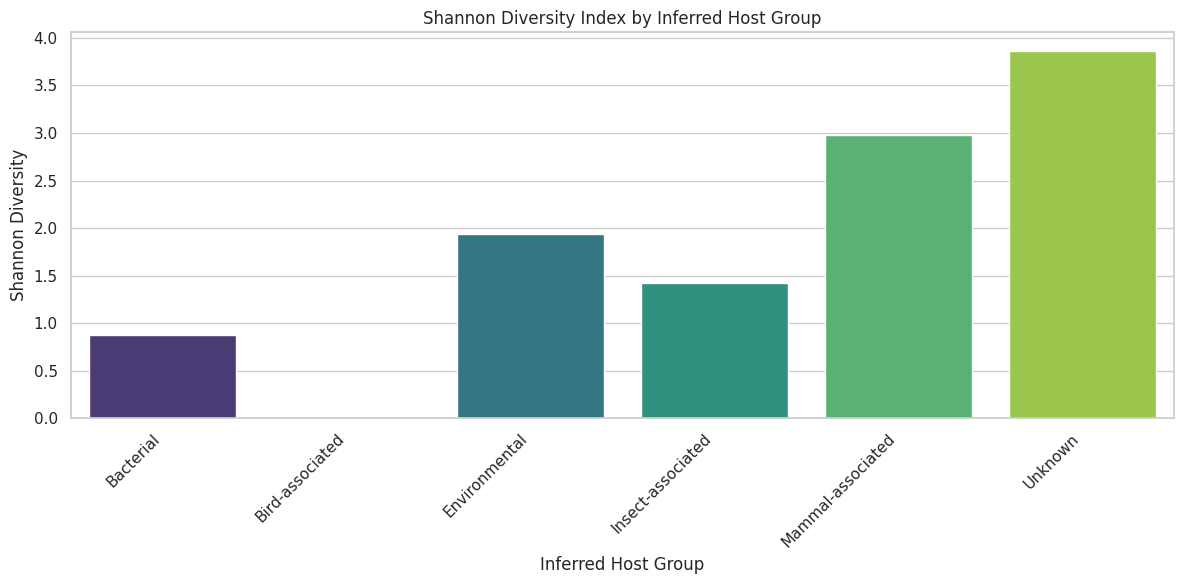

/tmp/ipython-input-2824695734.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


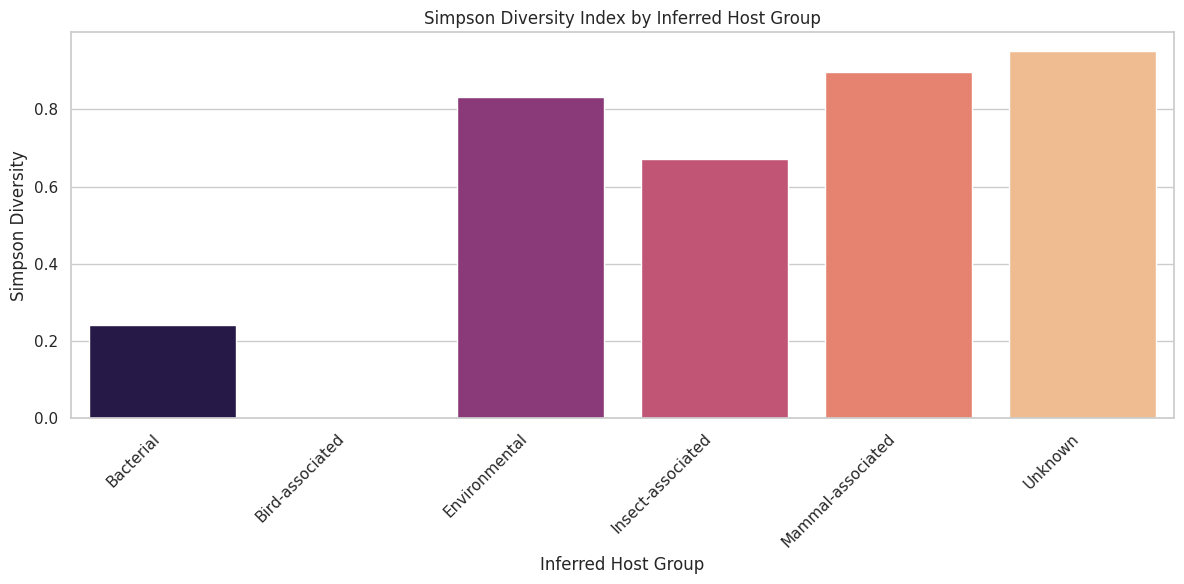

In [26]:
# ================================
# Host-specific diversity visualization
# ================================

# Shannon diversity by host inference
plt.figure(figsize=(12, 6))
sns.barplot(
    data=host_group_diversity,
    x="Host_Inference",
    y="Shannon_Diversity",
    palette="viridis"
)

plt.title("Shannon Diversity Index by Inferred Host Group")
plt.xlabel("Inferred Host Group")
plt.ylabel("Shannon Diversity")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Simpson diversity by host inference
plt.figure(figsize=(12, 6))
sns.barplot(
    data=host_group_diversity,
    x="Host_Inference",
    y="Simpson_Diversity",
    palette="magma"
)

plt.title("Simpson Diversity Index by Inferred Host Group")
plt.xlabel("Inferred Host Group")
plt.ylabel("Simpson Diversity")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



## Step 15: One Health relevance within dominant viral families


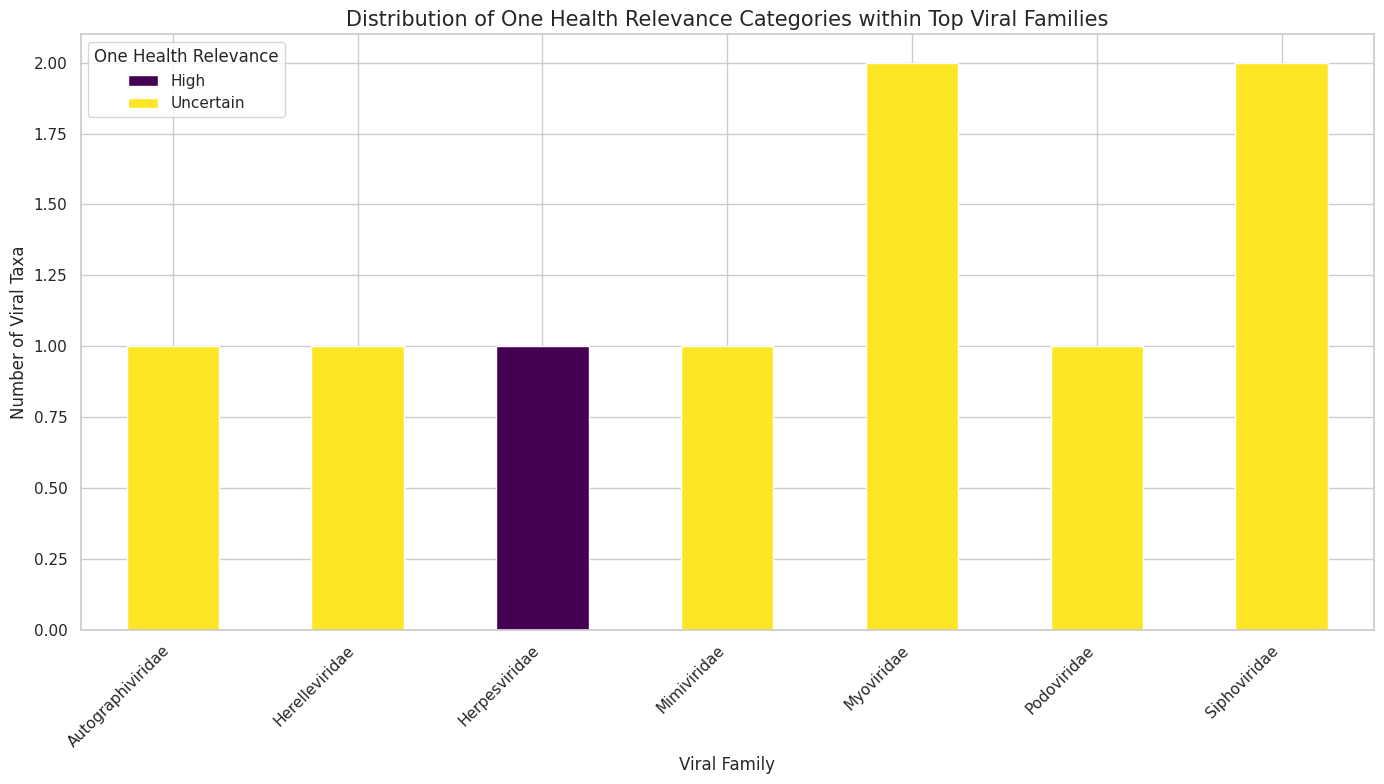

In [27]:
# ================================
# One Health relevance within top viral families
# ================================

# Get top family names (excluding unresolved)
top_family_names = top_families["Family_Assigned"].tolist()

# Filter dataframe to top families only
df_top_families = df[
    df["Family_Assigned"].isin(top_family_names)
]

# Crosstab: family × One Health relevance
risk_family_distribution = (
    df_top_families
    .groupby(["Family_Assigned", "OneHealth_Relevance"])
    .size()
    .unstack(fill_value=0)
)

# Plot stacked bar chart
plt.figure(figsize=(14, 8))
risk_family_distribution.plot(
    kind="bar",
    stacked=True,
    colormap="viridis",
    ax=plt.gca()
)

plt.title(
    "Distribution of One Health Relevance Categories within Top Viral Families",
    fontsize=15
)
plt.xlabel("Viral Family")
plt.ylabel("Number of Viral Taxa")
plt.xticks(rotation=45, ha="right")
plt.legend(title="One Health Relevance")

plt.tight_layout()
plt.show()


## Step 16: Export final analysis outputs


In [ ]:
# ================================
# Final export of analysis outputs
# ================================

import os

# Output directory
output_dir = "/content/drive/MyDrive/Virome_OneHealth_Results"
os.makedirs(output_dir, exist_ok=True)

# ----------------------------
# 1. Export main annotated table
# ----------------------------
df.to_csv(
    os.path.join(output_dir, "virome_annotated_table.csv"),
    index=False
)

# ----------------------------
# 2. Export alpha diversity
# ----------------------------
alpha_diversity.to_csv(
    os.path.join(output_dir, "alpha_diversity_metrics.csv"),
    index=False
)

# ----------------------------
# 3. Export host-specific diversity
# ----------------------------
host_group_diversity.to_csv(
    os.path.join(output_dir, "host_group_diversity.csv"),
    index=False
)

# ----------------------------
# 4. Export top families
# ----------------------------
top_families.to_csv(
    os.path.join(output_dir, "top_viral_families.csv"),
    index=False
)

# ----------------------------
# 5. Export One Health summary text
# ----------------------------
with open(os.path.join(output_dir, "one_health_summary.txt"), "w") as f:
    f.write(one_health_summary_text)

print("✅ Final outputs exported to:")
print(output_dir)
